# Problem
#### Can you identify sarcastic sentences? Can you distinguish between fake news and legitimate news?*

# Data
#### Each record consists of three attributes:*

* is_sarcastic: 1 if the record is sarcastic otherwise 0

* headline: the headline of the news article

* article_link: link to the original news article. Useful in collecting supplementary data

# Section 1: Necessary Libraries

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text
import re
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import f1_score, accuracy_score
import nltk
from nltk.corpus import stopwords

C:\Users\codehax41\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
sw = stopwords.words('english')

# Section 2 : Read Dataset

In [32]:
df1 = pd.read_json("Sarcasm_Headlines_Dataset.json",lines=True)
df1.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [33]:
df2 = pd.read_json("Sarcasm_Headlines_Dataset_v2.json",lines=True)
df2.head()

,article_link,headline,is_sarcastic
0,https://www.theonion.com/thirtysomething-scien...,thirtysomething scientists unveil doomsday clo...,1
1,https://www.huffingtonpost.com/entry/donna-edw...,dem rep. totally nails why congress is falling...,0
2,https://www.huffingtonpost.com/entry/eat-your-...,eat your veggies: 9 deliciously different recipes,0
3,https://local.theonion.com/inclement-weather-p...,inclement weather prevents liar from getting t...,1
4,https://www.theonion.com/mother-comes-pretty-c...,mother comes pretty close to using word 'strea...,1


### Shape of the Dataset

In [34]:
df1.shape

(26709, 3)

In [35]:
df2.shape

(28619, 3)

### Concatenating both the Dataset

In [36]:
data = pd.concat([df1, df2], axis = 0)

In [37]:
data.shape

(55328, 3)

### Some statistical analysis

In [38]:
data.describe()

,is_sarcastic
count,55328.000000
mean,0.458321
std,0.498264
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [39]:
# Checking dtypes
data.dtypes

article_link    object
headline        object
is_sarcastic     int64
dtype: object

In [40]:
# Checking Misssing Value
data.isnull().sum()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

### Checking some headlines

In [41]:
data['headline'].iloc[0]

"former versace store clerk sues over secret 'black code' for minority shoppers"

In [42]:
data['headline'].iloc[111]

'whale regrets eating 290,000 plastic poker chips that fell off container ship'

# Section 3: EDA and Feature Engineering

### Count Plot - Unique Labels

In [43]:
class TextHandler(HandlerBase):
    def create_artists(self, legend, tup ,xdescent, ydescent,
                        width, height, fontsize,trans):
        tx = Text(width/2.,height/2,tup[0], fontsize=fontsize,
                  ha="center", va="center", color=tup[1], fontweight="bold")
        return [tx]

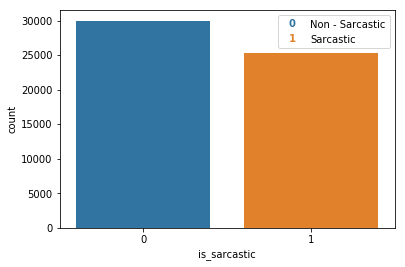

In [44]:
ax = sns.countplot(x='is_sarcastic', data=data)
handltext = ["0", "1"]
labels = ["Non - Sarcastic","Sarcastic"]
t = ax.get_xticklabels()
labeldic = dict(zip(handltext, labels))
labels = [labeldic[h.get_text()]  for h in t]
handles = [(h.get_text(),c.get_fc()) for h,c in zip(t,ax.patches)]
ax.legend(handles, labels, handler_map={tuple : TextHandler()}) 
plt.show()

*Here as we can see % of non-Sarcastic news is greater than Sarcastic News*

### Cleaning Text

The purpose of this step is to remove white space, including ” “, new lines, tabs and more.

In [45]:
# Cleaning Raw tweets
def clean_text(text):
    
    #remove emails
    text = ' '.join([i for i in text.split() if '@' not in i])
    
    #remove web address
    text = re.sub('http[s]?://\S+', '', text)
    
    #Filter to allow only alphabets
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    
    #Remove Unicode characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    
    #Convert to lowercase to maintain consistency
    text = text.lower()
    
    #remove double spaces 
    text = re.sub('\s+', ' ',text)
    
    return text

data["cleaned_headline"] = data.headline.apply(lambda x: clean_text(x))

### This step is traditionally an important step for natural language processing (NLP) tasks. It transforms text into a more digestible form so that machine learning algorithms can perform better.


### Removing stop words

In [46]:
# Remove stopwords from all the Headlines
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: ' '.join([word for word in x.split() if word not in (sw)]))

In [47]:
data.head()

,article_link,headline,is_sarcastic,cleaned_headline
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0,former versace store clerk sues secret 'black ...
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0,'roseanne' revival catches thorny political mo...
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1,mom starting fear son's web series closest thi...
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1,boehner wants wife listen come alternative deb...
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0,j k rowling wishes snape happy birthday magica...


## Sentiment Analysis

In [48]:
sid= SentimentIntensityAnalyzer()

### Calculating Polarity Score

- We use Polarity Score to check the positivity and negativity in a sentence. The key aspect of sentiment analysis is to analyze a body of text for understanding the opinion expressed by it. Typically, we quantify this sentiment with a positive or negative value, called polarity.

In [49]:
#Adding New Feature
data['scores'] = data['headline'].apply(lambda headline: sid.polarity_scores(headline))
data.head()

,article_link,headline,is_sarcastic,cleaned_headline,scores
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0,former versace store clerk sues secret 'black ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0,'roseanne' revival catches thorny political mo...,"{'neg': 0.272, 'neu': 0.576, 'pos': 0.152, 'co..."
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1,mom starting fear son's web series closest thi...,"{'neg': 0.198, 'neu': 0.802, 'pos': 0.0, 'comp..."
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1,boehner wants wife listen come alternative deb...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0,j k rowling wishes snape happy birthday magica...,"{'neg': 0.0, 'neu': 0.629, 'pos': 0.371, 'comp..."


### Compound Score

- The Compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1(most extreme negative) and +1 (most extreme positive).

In [50]:
#Adding New Features
data['compound'] =data['scores'].apply(lambda d:d['compound'])
data.head()

,article_link,headline,is_sarcastic,cleaned_headline,scores,compound
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0,former versace store clerk sues secret 'black ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0,'roseanne' revival catches thorny political mo...,"{'neg': 0.272, 'neu': 0.576, 'pos': 0.152, 'co...",-0.3182
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1,mom starting fear son's web series closest thi...,"{'neg': 0.198, 'neu': 0.802, 'pos': 0.0, 'comp...",-0.4939
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1,boehner wants wife listen come alternative deb...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0,j k rowling wishes snape happy birthday magica...,"{'neg': 0.0, 'neu': 0.629, 'pos': 0.371, 'comp...",0.6486


In [51]:
#Adding New feature
'''
Sarcastics (means funny so its compound score will be -ve) : So Compound Score annoted as : neg
Non Sarcastic (means non-funny so its compound score will be +ve) : S0 Compound Score annoted as : pos
'''
data['comp_score'] = data['compound'].apply(lambda score: 'pos' if score>=0 else 'neg')
data.head()

,article_link,headline,is_sarcastic,cleaned_headline,scores,compound,comp_score
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0,former versace store clerk sues secret 'black ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0,'roseanne' revival catches thorny political mo...,"{'neg': 0.272, 'neu': 0.576, 'pos': 0.152, 'co...",-0.3182,neg
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1,mom starting fear son's web series closest thi...,"{'neg': 0.198, 'neu': 0.802, 'pos': 0.0, 'comp...",-0.4939,neg
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1,boehner wants wife listen come alternative deb...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0,j k rowling wishes snape happy birthday magica...,"{'neg': 0.0, 'neu': 0.629, 'pos': 0.371, 'comp...",0.6486,pos


In [52]:
data1 =data.copy()

In [53]:
#Dropping Unnecessary Columns
data = data.drop(['article_link','headline','scores','compound'], axis = 1)

In [54]:
#Final Dataset before modelling
data.head()

,is_sarcastic,cleaned_headline,comp_score
0,0,former versace store clerk sues secret 'black ...,pos
1,0,'roseanne' revival catches thorny political mo...,neg
2,1,mom starting fear son's web series closest thi...,neg
3,1,boehner wants wife listen come alternative deb...,pos
4,0,j k rowling wishes snape happy birthday magica...,pos


# Section 4 : Model Building

### Train Test Split

In [55]:
x=data['cleaned_headline']
y=data['is_sarcastic']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.3,random_state=42)

- CountVectorizer does text preprocessing, tokenizing and filtering of stopwords and it builds a dictionary of features and transform documents to feature vectors.
- TfidfTransformer transforms the above vector by dividing the number of occurrences of each word in a document by the total number of words in the document. These new features are called tf for Term Frequencies.

### Transforming the training and test set

In [56]:
vect = CountVectorizer()
vect.fit(x_train)
X_train_dtm = vect.transform(x_train)
X_test_dtm = vect.transform(x_test)

### Applying Random Forest Algorithm

In [57]:
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train_dtm,y_train)
rf = model.predict(X_test_dtm)
print("Accuracy:",accuracy_score(y_test,rf)*100,"%")

Accuracy: 92.30676546779927 %


# Section 5: Classification Report and Confusion Matrix

Normalized confusion matrix
[[0.96 0.04]
 [0.12 0.88]]


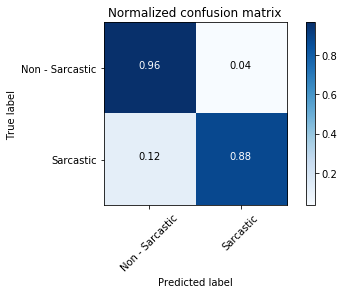

                 precision    recall  f1-score   support

Non - Sarcastic       0.90      0.96      0.93      8917
      Sarcastic       0.95      0.88      0.91      7682

      micro avg       0.92      0.92      0.92     16599
      macro avg       0.93      0.92      0.92     16599
   weighted avg       0.93      0.92      0.92     16599



In [58]:
import itertools  
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, rf)

np.set_printoptions(precision=2)
class_names = ['Non - Sarcastic','Sarcastic']
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

from sklearn.metrics import classification_report
eval_metrics = classification_report(y_test, rf, target_names=class_names)
print(eval_metrics)

## Conclusion :-

#### Have tried using Multiple Algorithms Like LinearSVC, Multinomial, Random Forest, Naive Bayes, SVM but only *Random Forest* performed best.

- Accuracy                            : 92.29% (For all prediction 92% predicted correctly)

- True Positive Rate             : 96% (Among all non-sarcastic labels, 96% predicted correctly)

- True Negative Rate            : 87% (Among all sarcastic labels, 87% predicted correctly)

- Misclassification Rate       : 8% (For all prediction 8% predicted incorrectly)

# Now using Word2Vec (Pending)

In [60]:
data1 = data1.drop(['article_link','headline','scores','comp_score'], axis=1)

In [61]:
data1.head()

,is_sarcastic,cleaned_headline,compound
0,0,former versace store clerk sues secret 'black ...,0.0000
1,0,'roseanne' revival catches thorny political mo...,-0.3182
2,1,mom starting fear son's web series closest thi...,-0.4939
3,1,boehner wants wife listen come alternative deb...,0.0000
4,0,j k rowling wishes snape happy birthday magica...,0.6486


In [119]:
from tqdm import tqdm
import sys
from nltk.tokenize import sent_tokenize, word_tokenize 
tqdm.pandas(desc="progress-bar")

In [136]:
data2 = data1['cleaned_headline']
data3 = [tok.strip() for tok in data2]

AttributeError: 'list' object has no attribute 'strip'

In [ ]:
data2['tokens']

# Thank You !